### LDA Topics clustering with Gensim

In [2]:
import pandas as pd
import gensim
from gensim import corpora, models

from modules.nlputils import StemFilterTokenizeProcessor

speeches_df = pd.read_csv('output/speeches/senate-speeches-201806.csv', index_col='CodigoPronunciamento')
speeches = speeches_df[['TextoIntegral']]
speeches = [s[0] for s in speeches.values[:]]

stopwords = set([line.strip() for line in open('stopwords.txt', 'r', encoding='utf-8')])
proc = StemFilterTokenizeProcessor(stopwords=stopwords, min_size=3, filter_regex='[a-z]', stem_language='portuguese', stem_complete=True, only_nouns=True)
tokens = proc.tokenize_documents(speeches)

dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(text) for text in tokens]
lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=4, id2word=dictionary, passes=100)
print(lda_model)
lda_model.print_topics(4)

LdaModel(num_terms=3763, num_topics=4, decay=0.5, chunksize=2000)


[(0,
  '0.010*"mundo" + 0.009*"violência" + 0.009*"gente" + 0.008*"resistência" + 0.007*"ministro" + 0.007*"tribunal" + 0.007*"mulheres" + 0.006*"polícia" + 0.006*"direito" + 0.006*"vida"'),
 (1,
  '0.012*"resistência" + 0.010*"gente" + 0.008*"mercado" + 0.008*"população" + 0.008*"energia" + 0.008*"preços" + 0.008*"educação" + 0.007*"preço" + 0.007*"bilhões" + 0.007*"petróleo"'),
 (2,
  '0.017*"rio" + 0.013*"mato" + 0.013*"grosso" + 0.012*"sul" + 0.010*"saúde" + 0.009*"região" + 0.009*"trabalho" + 0.007*"projeto" + 0.006*"cidade" + 0.006*"cidades"'),
 (3,
  '0.020*"projeto" + 0.015*"trabalhadores" + 0.011*"sessão" + 0.010*"câmara" + 0.009*"ordem" + 0.009*"preço" + 0.009*"direitos" + 0.008*"votação" + 0.008*"comissão" + 0.008*"deputados"')]

### LDA Topics clustering with Scikitlearn

In [3]:
import modules.scikitutils as scikitutils
from modules.nlputils import StemFilterTokenizeProcessor
import sys
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification

speeches_df = pd.read_csv('output/speeches/senate-speeches-201806.csv', index_col='CodigoPronunciamento')
speeches = speeches_df[['TextoIntegral']]
speeches = [s[0] for s in speeches.values[:]]
print('All speeches 06/2018')
print('qtty=' + str(len(speeches)))

stopwords = set([line.strip() for line in open('stopwords.txt', 'r', encoding='utf-8')])
# stopwords = []
proc = StemFilterTokenizeProcessor(min_size=3, filter_regex='[a-z]', stem_language='portuguese', stem_complete=True, only_nouns=True)

tf_vectorizer = CountVectorizer(min_df=0.1, max_df=1.0, stop_words=stopwords, preprocessor=proc.process_text)
tf = tf_vectorizer.fit_transform(speeches)
tf_feature_names = tf_vectorizer.get_feature_names()

lda = LatentDirichletAllocation(n_topics=4, max_iter=200, learning_method='batch', random_state=0, n_jobs=2)
lda.fit(tf)

scikitutils.display_lda_topics(lda, tf_feature_names, 5)

All speeches 06/2018
qtty=466


/usr/local/lib/python3.5/dist-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Topic 0: trabalhadores preço mercado bilhões resistência 
Topic 1: rio trabalho sul mundo violência 
Topic 2: gente ministro ministério direito tribunal 
Topic 3: projeto câmara sessão ordem deputado 


### Clusterize with KMeans

In [4]:
import pandas as pd
from modules.nlputils import StemFilterTokenizeProcessor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import MiniBatchKMeans, KMeans

speeches_df = pd.read_csv('output/speeches/senate-speeches-201806.csv', index_col='CodigoPronunciamento')
speeches = speeches_df[['TextoIntegral']]
speeches = [s[0] for s in speeches.values[:]]

stopwords = set([line.strip() for line in open('stopwords.txt', 'r', encoding='utf-8')])
proc = StemFilterTokenizeProcessor(min_size=3, filter_regex='[a-z]', stem_language='portuguese', stem_complete=True, only_nouns=True)

vec = TfidfVectorizer(min_df=0.1, stop_words=stopwords, analyzer='word', ngram_range=(1, 2), preprocessor=proc.process_text)
X = vec.fit_transform(speeches)

number_of_clusters = 4
kmeans_model = KMeans(n_clusters=number_of_clusters)
speech_groups = kmeans_model.fit_predict(X)

order_centroids = kmeans_model.cluster_centers_.argsort()[:, ::-1]
terms = vec.get_feature_names()
cluster_labels = []
for i in range(number_of_clusters):
    top_words = [terms[ind] for ind in order_centroids[i, :5]]
    gl = "Cluster {}: {}".format(i, ' '.join(top_words))
    print(gl)
    cluster_labels.append(gl)

results = pd.DataFrame()
results['speeches'] = speeches
results['category'] = kmeans_model.labels_

for index, row in results[:5].iterrows():
    print('========')
    print(str(row['category']) + ' ' + cluster_labels[row['category']] + ' ' + row['speeches'])


Cluster 0: veto rio rio sul sul região
Cluster 1: preço petróleo gasolina setor nordeste
Cluster 2: resistência gente projeto mundo brasileiros
Cluster 3: ordem votação sessão deputado plenário
1 Cluster 1: preço petróleo gasolina setor nordeste      O SR. ROBERTO REQUIÃO  (Bloco Maioria/MDB - PR. Pronuncia o seguinte discurso. Sem revisão do orador.) – Senador Presidente, Senador Paim, vou aproveitar esta sexta-feira para repetir o mantra que eu venho repetindo com insistência sobre o que realmente está acontecendo no Brasil. Nós não estamos, Senador Paim, descolados de uma circunstância global. O que acontece no Brasil, acontece em outros países também.     O Papa Francisco, quando os governantes mais poderosos do mundo se reuniam em Davos, com os homens mais ricos da Terra, os concentradores do capital, dizia: "O capital é bom quando ele é investido, gera empregos, produtos, inova na tecnologia, mas o capital tem que servir à sociedade e não pode dominá-la." Na verdade, o que o Papa

### Find alike speeches

In [9]:
import pandas as pd
from modules.nlputils import StemFilterTokenizeProcessor
from sklearn.feature_extraction.text import TfidfVectorizer

speeches_df = pd.read_csv('output/speeches/senate-speeches-201806.csv', index_col='CodigoPronunciamento')
speeches = speeches_df[['TextoIntegral']]
speeches = [s[0] for s in speeches.values[:]]

# stopwords = set([line.strip() for line in open('stopwords.txt', 'r', encoding='utf-8')])
stopwords = []
proc = StemFilterTokenizeProcessor(min_size=3, filter_regex='[a-z]', stem_language='portuguese', stem_complete=True, only_nouns=True)

vec = TfidfVectorizer(min_df=0.1, stop_words=stopwords, analyzer='word', ngram_range=(1, 2), preprocessor=proc.process_text)
X = vec.fit_transform(speeches)

In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

#calculate NxN cosine distante between all elements
similarity_cos = (X * X.T).toarray()

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(similarity_cos, mask=np.zeros_like(similarity_cos, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

NameError: name 'X' is not defined

### Find alike sents

In [10]:
import pandas as pd
import numpy as np
from modules.nlputils import StemFilterTokenizeProcessor
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import sent_tokenize

speeches_df = pd.read_csv('output/speeches/senate-speeches-201806.csv', index_col='CodigoPronunciamento')
speeches = speeches_df[['TextoIntegral']]
speeches = [s[0] for s in speeches.values[:]]

sents = []
for s in speeches[:20]:
    for st in sent_tokenize(s):
        sents = np.append(sents, st)
sents = [s for s in sents if len(s)>60]

# stopwords = set([line.strip() for line in open('stopwords.txt', 'r', encoding='utf-8')])
stopwords = []
proc = StemFilterTokenizeProcessor(min_size=3, filter_regex='[a-z]', stem_language='portuguese', stem_complete=True, only_nouns=True)

vec = TfidfVectorizer(min_df=0.1, stop_words=stopwords, analyzer='word', ngram_range=(1, 2), preprocessor=proc.process_text)
X = vec.fit_transform(sents)

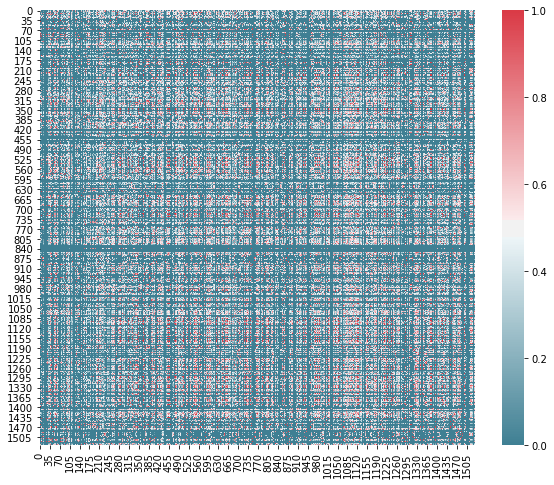

In [14]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

#calculate NxN cosine distante between all elements
similarity_cos = (X * X.T).toarray()

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(similarity_cos, cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [17]:
for a in range(len(similarity_cos)):
    for b in range(len(similarity_cos[a])):
        v = similarity_cos[a][b]
        if v>0.97 and a!=b:
            print(sents[a] + ' ~= ' + sents[b] + ': ' + str(v))

Nós não estamos, Senador Paim, descolados de uma circunstância global. ~= Eu sou advogado, Senador Paim, e não consigo entender uma prisão, um crime sem corpo do delito.: 1.0
Na verdade, o que o Papa estava repetindo é o velho dito bíblico: "Não se pode servir a Deus e a Mamon." ~= Ele não vai produzir o que não pode ser comprado, o que ele não pode vender.: 0.9858260441784878
Na verdade, o que o Papa estava repetindo é o velho dito bíblico: "Não se pode servir a Deus e a Mamon." ~= O livre mercado: e bota o Exército a reprimir as pessoas que não aceitam o aumento absurdo do mercado, um mercado monopolizado.: 1.0
Na verdade, o que o Papa estava repetindo é o velho dito bíblico: "Não se pode servir a Deus e a Mamon." ~= Está desprezando a população que não tem acesso ao mercado de trabalho e ao mercado de consumo.: 1.0
Na verdade, o que o Papa estava repetindo é o velho dito bíblico: "Não se pode servir a Deus e a Mamon." ~= Não são os mesmos corruptos que mantinham os diretores da Petr

Mas um industrial chamado Henry Ford se suporta nas ideias do economista Taylor. ~= Petróleo é tarifa pública, como é telefone, como é eletricidade, como é água, como é esgoto, mas o Estado se omite de controlá-lo e o deixa na mão de interesses de empresas petroleiras estrangeiras e de alguns importadores.: 1.0
Mas um industrial chamado Henry Ford se suporta nas ideias do economista Taylor. ~= Na verdade, são cerca de 400 importadores, mas os significativos são a Shell, a Cosan e a Ipiranga.: 1.0
Mas um industrial chamado Henry Ford se suporta nas ideias do economista Taylor. ~= Todos já tinham acertado, mas, como a figura principal era ele, aí me deu a oportunidade, claro, de falar.: 1.0
Mas um industrial chamado Henry Ford se suporta nas ideias do economista Taylor. ~= A Srª Vanessa Grazziotin  (Bloco Parlamentar Democracia e Cidadania/PCdoB - AM) – ... mas eu nunca vi na minha vida – nunca vi na minha vida – gasolina aumentar todo dia.: 1.0
Mas um industrial chamado Henry Ford se su

É uma satisfação ver o retorno de V. Exª à Casa, já presidindo a sessão. ~= No Brasil, agora ficou uma coisa... As pessoas falam assim: "Ah, ninguém consegue fazer nada em um mandato.": 1.0
É uma satisfação ver o retorno de V. Exª à Casa, já presidindo a sessão. ~= O Sr. José Medeiros  (Bloco Parlamentar Democracia e Cidadania/PODE - MT) – ... tão inquietante, como dizia aquele livro do Al Gore, Uma Verdade Inconveniente.: 1.0
É uma satisfação ver o retorno de V. Exª à Casa, já presidindo a sessão. ~= Eu apresentei essas PECs e esses projetos no sentido de termos uma política melhor, de termos uma política diferente.: 1.0
É uma satisfação ver o retorno de V. Exª à Casa, já presidindo a sessão. ~= O Sr. Paulo Paim  (Bloco Parlamentar da Resistência Democrática/PT - RS) – ... e demitir 5 mil trabalhadores, e fechar 500 agências, porque V. Exª já fez pronunciamento contrário a isso, assim como eu – inclusive, realizamos uma audiência pública.: 1.0
É uma satisfação ver o retorno de V. Exª 

A população precisa entender que essa defesa do livre mercado é contra o Brasil, é contra o crescimento do País, é contra o nosso desenvolvimento industrial. ~= O SR. ACIR GURGACZ  (Bloco Parlamentar da Resistência Democrática/PDT - RO) – ... rondonienses que iriam participar de um evento religioso em Manaus e foram resgatados pelo Exército brasileiro e também pela PRF.: 1.0
A população precisa entender que essa defesa do livre mercado é contra o Brasil, é contra o crescimento do País, é contra o nosso desenvolvimento industrial. ~= A falta de manutenção é que provocou o abandono dessa rodovia, as interrupções e a queda do asfalto.: 1.0
A população precisa entender que essa defesa do livre mercado é contra o Brasil, é contra o crescimento do País, é contra o nosso desenvolvimento industrial. ~= Hoje, essa matéria é regulada pelo Conama, sem a devida força de lei e sem ter passado pelo foro de debate do Congresso Nacional, o que tem acarretado discrepâncias nos critérios e parâmetros ad

É autor de um projeto que, para mim, vai na linha da cidadania. ~= Porque eles se acostumaram a que a receita de bolo para chegar ao poder é levantar o problema e apontar o culpado.: 1.0000000000000002
É autor de um projeto que, para mim, vai na linha da cidadania. ~= Eu falei: "Meu Deus do céu, como é que tem cara de pau para isso?".: 1.0000000000000002
É autor de um projeto que, para mim, vai na linha da cidadania. ~= Que o povo pague para os acionistas privados da Petrobras, que o povo pague para a Shell, que o povo pague para a Ipiranga, porque é isso que estão fazendo.: 0.9904384808888954
É autor de um projeto que, para mim, vai na linha da cidadania. ~= E, se tira impostos, tira recursos que o Estado arrecadaria para ser investidos nos programas sociais, ou tira diretamente o dinheiro da saúde, o dinheiro da educação.: 1.0000000000000002
É autor de um projeto que, para mim, vai na linha da cidadania. ~= É urgente que este Governo irresponsável aja para assegurar a paz social e co

Aí é um exemplo de que, na Venezuela, a PDV, que é a Petrobras deles, mantém o preço do petróleo e da gasolina quase zero. ~= A atrocidade de que foi vítima - que é a atrocidade de que são vítimas tantas crianças todos os dias - precisa ter um fim.: 1.0
Aí é um exemplo de que, na Venezuela, a PDV, que é a Petrobras deles, mantém o preço do petróleo e da gasolina quase zero. ~= Lembramos que o Honraria Naiara Soares Gomes será entregue todos os anos no dia 4 de junho - Dia Internacional das Crianças Inocentes Vítimas de Agressão.: 1.0
Aí é um exemplo de que, na Venezuela, a PDV, que é a Petrobras deles, mantém o preço do petróleo e da gasolina quase zero. ~= Um estudo do Departamento Intersindical de Estatística e Estudos Socioeconômicos, que está publicado na imprensa através de nota técnica, esclarece que a política de preços resultou, entre o final de abril e maio, em 16 reajustes do preço da gasolina e do diesel nas refinarias.: 1.0
Aí é um exemplo de que, na Venezuela, a PDV, que é

Eu sou Senador de Brasília, Hélio José, e a Vanessa Grazziotin, que vai falar agora, neste aparte, é Senadora do Amazonas, a quem o Senador Cristovam acabou de passar a palavra. ~= DISCURSOS NA ÍNTEGRA ENCAMINHADOS PELO SR. SENADOR PAULO PAIM.: 0.9871903199615257
Eu sou Senador de Brasília, Hélio José, e a Vanessa Grazziotin, que vai falar agora, neste aparte, é Senadora do Amazonas, a quem o Senador Cristovam acabou de passar a palavra. ~= Sr. Presidente, apenas encaminhando "sim", tanto em relação às emendas, quanto em relação ao projeto, parabenizando o Senador autor do projeto e o Relator pelo brilhante Substitutivo, Sr. Presidente.: 0.9871903199615257
A Srª Vanessa Grazziotin  (Bloco Parlamentar Democracia e Cidadania/PCdoB - AM) – Muito obrigada, Senador Cristovam. ~= Meus cumprimentos, inclusive, ao Senador Telmário Mota e, ao mesmo tempo, ao retorno de V. Exª.: 1.0
A Srª Vanessa Grazziotin  (Bloco Parlamentar Democracia e Cidadania/PCdoB - AM) – Muito obrigada, Senador Cristova

O sistema político tem que ser constantemente oxigenado, renovado. ~= Ele tenta evitar que a Petrobras consiga empréstimos no mercado internacional.: 1.0
O sistema político tem que ser constantemente oxigenado, renovado. ~= O presidente e os vice-presidentes que estão mandando no Brasil hoje e tocando a flauta do neoliberalismo são os mesmos; eles estão no Governo.: 1.0
O sistema político tem que ser constantemente oxigenado, renovado. ~= É preciso que se quantifique quanto ganharam a Cosan, a Copel e as grandes empresas importadoras, a Ipiranga.: 1.0
O sistema político tem que ser constantemente oxigenado, renovado. ~= A população precisa entender que essa defesa do livre mercado é contra o Brasil, é contra o crescimento do País, é contra o nosso desenvolvimento industrial.: 1.0
O sistema político tem que ser constantemente oxigenado, renovado. ~= O livre mercado é que vai resolver o problema, a mão invisível do mercado.": 1.0
O sistema político tem que ser constantemente oxigenado, r

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Paulo Parente foi o Ministro do apagão do PSDB no Governo Fernando Henrique Cardoso e agora do apagão de combustível de Temer, que causou danos imensos ao Brasil e aos brasileiros, colocou o País em um colapso generalizado e provocou elevadas perdas financeiras à empresa. ~= Hoje eu li um documento de um engenheiro da Petrobras que mostra que a Petrobras é superavitária.: 1.0
Paulo Parente foi o Ministro do apagão do PSDB no Governo Fernando Henrique Cardoso e agora do apagão de combustível de Temer, que causou danos imensos ao Brasil e aos brasileiros, colocou o País em um colapso generalizado e provocou elevadas perdas financeiras à empresa. ~= Eu queria muito que os presidenciáveis começassem a falar sobre isso também.: 1.0
Paulo Parente foi o Ministro do apagão do PSDB no Governo Fernando Henrique Cardoso e agora do apagão de combustível de Temer, que causou danos imensos ao Brasil e aos brasileiros, colocou o País em um colapso generalizado e provocou elevadas perdas financeiras à

O Tenente-Coronel reformado Paulo Malhães [...] [é quem] disse que os animais eram dele e foram capturados no Rio Araguaia, na Região Amazônica, durante a campanha militar contra a guerrilha [...]. ~= Então, dessa forma, apresentei este projeto que hoje está em discussão nesta Casa.: 1.0
O Tenente-Coronel reformado Paulo Malhães [...] [é quem] disse que os animais eram dele e foram capturados no Rio Araguaia, na Região Amazônica, durante a campanha militar contra a guerrilha [...]. ~= Em 11 de outubro de 1977, o Presidente Ernesto Geisel sancionou a lei que criou o Estado de Mato Grosso do Sul, desmembrando terras do antigo Estado de Mato Grosso.: 1.0
Malhães, que usava o codinome "doutor Pablo", trabalhava no Centro de Informações do Exército em Petrópolis, a chamada "casa da morte", onde de 20... (Soa a campainha.) ~= É evidente que as resistências se estabeleceram e continuam ainda firmes.: 1.0
Malhães, que usava o codinome "doutor Pablo", trabalhava no Centro de Informações do Exér

Não há nenhum impacto ambiental em refazer o asfalto numa rodovia que já foi asfaltada. ~= Quer dizer, eu não gosto do Reguffe porque ele só fala de contribuinte ou é porque o Reguffe é um cara sério e tem ideias diferentes da onda que está aí?: 1.0
Não há nenhum impacto ambiental em refazer o asfalto numa rodovia que já foi asfaltada. ~= Então, assim, não faz...     Primeiro, eu economizo de verdade, e o que nossa sociedade está precisando hoje é de exemplos.: 1.0
Não há nenhum impacto ambiental em refazer o asfalto numa rodovia que já foi asfaltada. ~= Muita gente fala que não vai passar, que não tem chance de passar.: 1.0
Não há nenhum impacto ambiental em refazer o asfalto numa rodovia que já foi asfaltada. ~= O reajuste da gasolina não pode ser diário; tem que ser pelo menos mensal.": 1.0
Não há nenhum impacto ambiental em refazer o asfalto numa rodovia que já foi asfaltada. ~= Não vou citar agora porque, como há muitas fake news, estou acreditando que é fake news.: 1.0
Não há nen

Reparem que esta isenção de impostos só é válida para as empresas estrangeiras. ~= Eu dou o maior dez para ele e quero desejar inclusive que ele ganhe as eleições.: 1.0000000000000002
Reparem que esta isenção de impostos só é válida para as empresas estrangeiras. ~= Aliás, tudo o que ultimamente tem acontecido, no País, em termos de crise, tem caído para eles, em boa parte, resolverem.: 1.0000000000000002
Reparem que esta isenção de impostos só é válida para as empresas estrangeiras. ~= Porque eles se acostumaram a que a receita de bolo para chegar ao poder é levantar o problema e apontar o culpado.: 1.0000000000000002
Reparem que esta isenção de impostos só é válida para as empresas estrangeiras. ~= Eu falei: "Meu Deus do céu, como é que tem cara de pau para isso?".: 1.0000000000000002
Reparem que esta isenção de impostos só é válida para as empresas estrangeiras. ~= Que o povo pague para os acionistas privados da Petrobras, que o povo pague para a Shell, que o povo pague para a Ipira

Eu sei que você defende a democracia e 16 centavos de auxílio-família é, de fato, um absurdo". ~= Quando a pessoa fica muito tempo num cargo, ela vai se esquecendo de que é apenas um representante; ela começa a se achar proprietária do cargo e vai se esquecendo de que é apenas um representante.: 1.0
Eu sei que você defende a democracia e 16 centavos de auxílio-família é, de fato, um absurdo". ~= A minha proposta é a seguinte: a Justiça Eleitoral faria licitações; a gráfica que ganhasse imprimiria o panfleto de todos os candidatos àquele determinado cargo, naquele determinado lugar – mesma quantidade, mesmo formato, a diferencia seria o conteúdo.: 1.0
Eu sei que você defende a democracia e 16 centavos de auxílio-família é, de fato, um absurdo". ~= A PEC 6 de 2015, que apresentei também no início do meu mandato, também na primeira semana do meu mandato, permite que as pessoas possam ser candidatas sem filiação partidária.: 1.0
Eu sei que você defende a democracia e 16 centavos de auxílio

Esses percentuais são muito inferiores ao mínimo ofertado em Libra, no Edital da Primeira Rodada, que foi de 41,65%. ~= A atrocidade de que foi vítima - que é a atrocidade de que são vítimas tantas crianças todos os dias - precisa ter um fim.: 1.0
Esses percentuais são muito inferiores ao mínimo ofertado em Libra, no Edital da Primeira Rodada, que foi de 41,65%. ~= Lembramos que o Honraria Naiara Soares Gomes será entregue todos os anos no dia 4 de junho - Dia Internacional das Crianças Inocentes Vítimas de Agressão.: 1.0
Esses percentuais são muito inferiores ao mínimo ofertado em Libra, no Edital da Primeira Rodada, que foi de 41,65%. ~= Um estudo do Departamento Intersindical de Estatística e Estudos Socioeconômicos, que está publicado na imprensa através de nota técnica, esclarece que a política de preços resultou, entre o final de abril e maio, em 16 reajustes do preço da gasolina e do diesel nas refinarias.: 1.0
Esses percentuais são muito inferiores ao mínimo ofertado em Libra, 

Um estudo do Departamento Intersindical de Estatística e Estudos Socioeconômicos, que está publicado na imprensa através de nota técnica, esclarece que a política de preços resultou, entre o final de abril e maio, em 16 reajustes do preço da gasolina e do diesel nas refinarias. ~= E este é o Senado da República Federativa do Brasil, que também tem a responsabilidade de governar este Brasil.: 1.0
Um estudo do Departamento Intersindical de Estatística e Estudos Socioeconômicos, que está publicado na imprensa através de nota técnica, esclarece que a política de preços resultou, entre o final de abril e maio, em 16 reajustes do preço da gasolina e do diesel nas refinarias. ~= Senadores, Senadoras, ouvintes que nos acompanham pela Rádio Senado, telespectadores que nos acompanham pela TV Senado e os internautas que nos seguem nas redes sociais.: 1.0
Um estudo do Departamento Intersindical de Estatística e Estudos Socioeconômicos, que está publicado na imprensa através de nota técnica, esclar

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

